In [1]:
import os
import mido
import utils ##
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Datos preprocesados:
https://drive.google.com/drive/folders/1jzfK-VM_Qb76K31Y7iMpsi1JeQ7QqU5W?usp=sharing

# Importar Datos

In [2]:
df_midis_info = pd.read_csv('datos_procesados/midis/midis_info.csv', index_col=0)
df_midis_notas = pd.read_csv('datos_procesados/midis/midis_notas.csv', index_col=0)

In [3]:
# Tipos de MIDI
df_non_standard = pd.read_csv('datos_procesados/midis/tipos/no_estandar.csv', index_col=0)
df_standard = pd.read_csv('datos_procesados/midis/tipos/estandar.csv', index_col=0)

In [4]:
# Usar los audios con expresión MIDI estándar
df_midi = df_standard.merge(df_midis_info, how='left', left_index=True, right_index=True)
df_midi = df_midi.drop(columns=['problem?'])
df_midi = df_midi.rename({'velocity':'velocity_start'}, axis=1)

df_notas = df_midis_notas.loc[df_midi.index]

# MIDIS

In [5]:
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


### Filtrar frecuencias
Sólo se conservan aquellas que son alcanzables por una voz humana

In [14]:
### Filtra notas que no son ejecutadas
notas_mask = (df_notas.sum() > 0)
notas_ejecutadas = notas_mask[notas_mask]

# Transforma en DataFrame
notas_ejecutadas = notas_ejecutadas.index.str.extract('(^\d+) \((\w#?\d)\)') # Separa la clave MIDI del Cifrado
notas_ejecutadas = notas_ejecutadas.rename({0:'midi-ET', 1: 'cifrado'}, axis=1) # Renombrar
notas_ejecutadas['midi-ET'] = notas_ejecutadas['midi-ET'].astype(int) # Regresar a numérico
notas_ejecutadas['herts-ET'] = utils.preprocess.nota_a_frequencia(notas_ejecutadas['midi-ET']) # Convertir a frecuencia

In [15]:
# Calcular cotas de filtrado
hz_std = notas_ejecutadas['herts-ET'].std() 

hz_lb = np.floor( notas_ejecutadas['herts-ET'].min() * (1-0.5) )
hz_ub = np.ceil( notas_ejecutadas['herts-ET'].max() + 0.5*hz_std )

freq_range = (hz_lb, hz_ub)
print(f'Rango de frecuencias utilizable (Hz): {freq_range}')

Rango de frecuencias utilizable (Hz): (18.0, 1167.0)


### Reducción dimensión de tiempo

La reducción se realiza a un tiempo $T$ siguiendo los siguientes pasos para garantizar la integridad de las notas:

- Recortar tiempo muerto al inicio del MIDI
- Encontrar el punto de corte en $T$ del MIDI
- Verificar si hay una nota sonando
- Eliminar la nota sonando
- Capturar el tiempo $t_f$ en la que termina la última nota ($t_f \leq 10$)

In [23]:
def procesar_midis(midi_names, output_folder, T):
    """
    Aplica las funciones de recorte de desfase de tiempo inicial (lstrip) y ajuste a T segundos 
    a todos los archivos MIDI en una carpeta.
    
    Parámetros:
        midi_names (Series): Nombres de los MIDI a convertir.
        output_folder (str): Carpeta de destino para guardar los archivos MIDI procesados.
        T (float): Duración máxima en segundos para los archivos MIDI procesados.
    """
    # Revisar carpeta de salida
    os.makedirs(output_folder, exist_ok=True)
    # Definir carpeta de MIDIs
    input_folder = 'datos/MIDIs/midi_data/'

    
    for midi_name in midi_names:
        midi_path = os.path.join(input_folder, midi_name + '.mid')
        mid = mido.MidiFile(midi_path)
        
        # Recortar tiempo muerto
        mid = utils.midi.lstrip(mid)
        
        # Recortar duración a T segundos
        tempo = df_midi['tempo_ms'].loc[midi_name]
        mid = utils.midi.trim(mid, tempo, T)
        
        # Guardar el archivo MIDI procesado
        output_path = os.path.join(output_folder, midi_name + '.mid')
        mid.save(output_path)


In [24]:
procesar_midis(midi_names=df_midi.index,
               output_folder='datos_procesados/midis/trimmed/',
               T=10)

# Tarareos


In [3]:
path = 'datos/Tarareos/test/'
# Duración de la ventana en milisegundos
L = 55  # por ejemplo, 500 milisegundos

# Procesar los archivos de audio y generar los espectrogramas
spectro = utils.tarareos.process_audio_files(path, L)
#%#%#%#%#%#%#%#%#%#%#%#%

In [257]:
# T_audio > 10 : F04_0300_0001_1_D
# T_audio = 10 : F01_0009_0001_2_D
# T_audio < 10 : F01_0035_0001_2_D
# Nota sonando en T : F01_0028_0003_2_D
# Nota no sonando en T: F01_0022_0001_1_D

In [17]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0022_0001_1_D.wav' 
y, sr = librosa.load(audio_path, sr=None)
y.shape[0] / sr

10.0

In [18]:
midi = mido.MidiFile('datos_procesados/midis/trimmed/F01_0022_0001_1_D.mid')
midi.length

10.0

In [19]:
foo_y = utils.tarareos.trim(y, sr=sr, T_midi=midi.length, T_audio=10)
foo_y.shape[0] / sr

9.496961451247165

In [20]:
foo_y.shape[0]

418816

In [21]:
L_seg = lowest_time / 2
foo_frames, foo_L = utils.tarareos.dividir_en_ventanas(foo_y, sr, L_seg = L_seg)
print(foo_L)
foo_frames.shape

2756


(2756, 151)

In [22]:
freq_range

(18.0, 1167.0)

In [23]:
foo_spectro, foo_freqs = generar_espectrograma(foo_y, sr, foo_L, freq_range)
foo_spectro.shape

(70, 152)

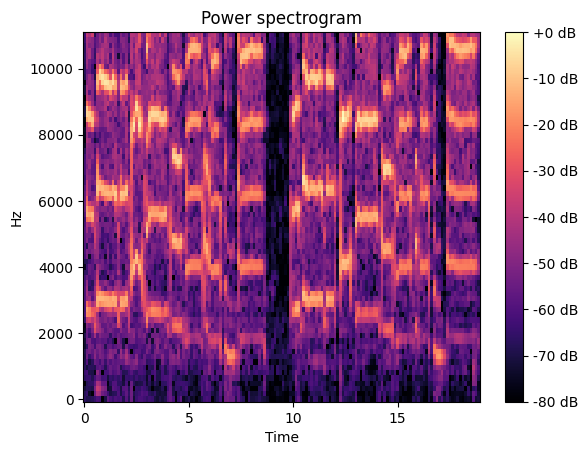

In [24]:
fig, ax = plt.subplots()
img = librosa.display.specshow(foo_spectro,
                               y_axis='fft', x_axis='time', ax=ax, hop_length=foo_L)
ax.set_title('Power spectrogram')
# for i in range(157):
#     ax.vlines(i * L_seg, 0, 8192)
fig.colorbar(img, ax=ax, format="%+2.0f dB")

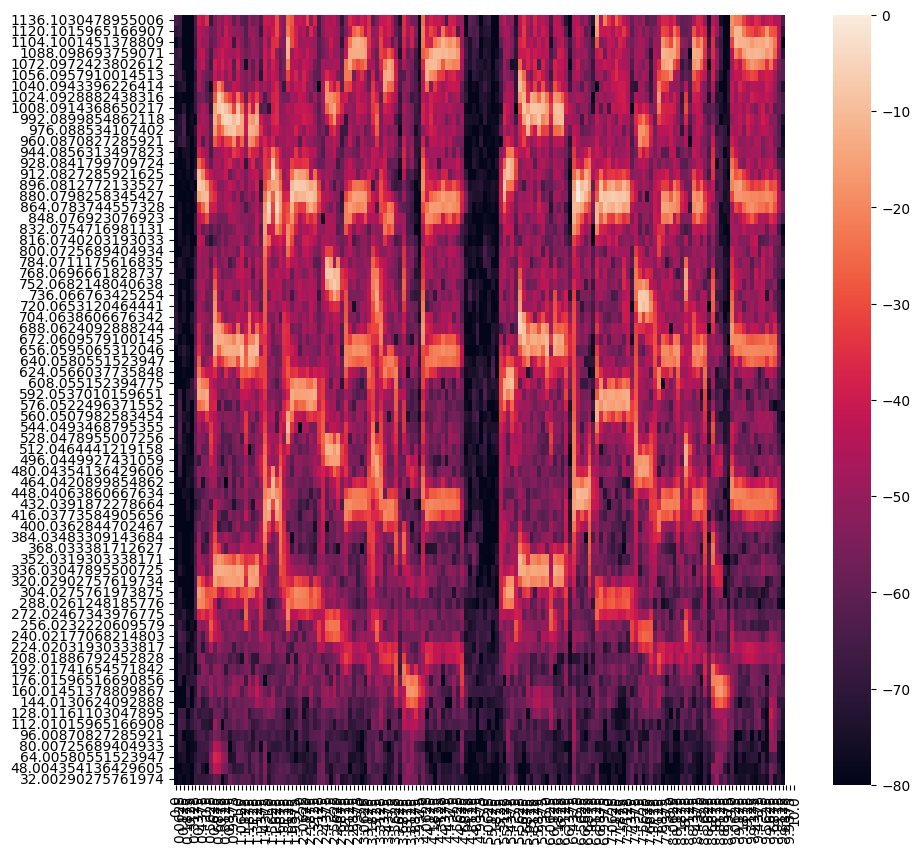

In [119]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))       

sns.heatmap(foo_spectro, yticklabels=foo_freqs, xticklabels=[i*L_seg for i in range(161)], ax=ax)
ax.invert_yaxis()

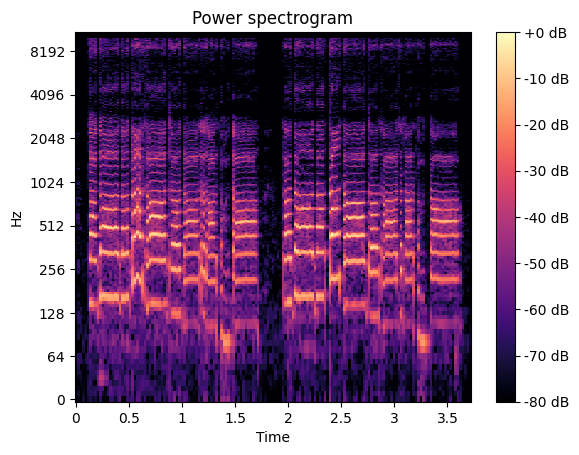

In [105]:
y, sr = librosa.load('datos\Tarareos\wav_data_sync_with_midi\F01_0022_0001_1_D.wav', sr=None, duration=10)

L_segs = lowest_time/2
L = int(sr * L_segs)
S = librosa.stft(y, n_fft=L, hop_length=L)
S_magnitude = np.abs(S)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_magnitude,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Otros

In [17]:
midi = mido.MidiFile('Datos/MIDIs/midi_data/F04_0300_0001_1_D.mid')
midi

MidiFile(type=1, ticks_per_beat=1024, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=857143, time=0),
    MetaMessage('key_signature', key='C', time=0),
    MetaMessage('time_signature', numerator=2, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1024)]),
  MidiTrack([
    MetaMessage('track_name', name='é\x92¢ç\x90´, Piano', time=0),
    Message('program_change', channel=0, program=0, time=0),
    Message('pitchwheel', channel=0, pitch=0, time=0),
    Message('program_change', channel=0, program=0, time=0),
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=65, velocity=80, time=0),
    Message('note_off', channel=0, note=65, velocity=0, time=768),
    Message('note_on', channel=0, note=62, velocity=80, time=0),
    Message('note_off', channel=0, note=62, velocity=0, time=256),
    Message('note_on', channel=0, note=60, velocity=80, time=0),
    Message('note_o